In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df_f = pd.read_csv("C:/Users/user/Desktop/df_f_final.csv", low_memory=False)

In [4]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303519 entries, 0 to 1303518
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   actual_class     1303519 non-null  int64  
 1   issue_year       1303519 non-null  int64  
 2   issue_month      1303519 non-null  int64  
 3   id               1303519 non-null  int64  
 4   uncon_PD         1303519 non-null  float64
 5   predicted_class  1303519 non-null  int64  
 6   issue_d          1303519 non-null  object 
 7   grade            1303519 non-null  object 
 8   total_pymnt      1303519 non-null  float64
 9   exposure         1303519 non-null  float64
 10  loss             1303519 non-null  float64
 11  loss_rate        1303519 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 119.3+ MB


In [5]:
df_f = df_f[df_f['grade'].isin(['G', 'F','E'])].copy()

In [6]:
import numpy as np
import pandas as pd

# Define the Basel correlation function
def basel_correlation(pd):
    if pd < 0 or pd > 1:
        raise ValueError("Probability of default (pd) should be between 0 and 1.")
    term1 = 0.03 * (1 - np.exp(-35 * pd)) / (1 - np.exp(-35))
    term2 = 0.16 * (1 - (1 - np.exp(-35 * pd)) / (1 - np.exp(-35)))
    return term1 + term2

# Assuming df_f is your DataFrame and it has the columns 'uncon_PD' for probability of default and 'exposure'
# Calculate the correlation for each entry
df_f['correlation'] = df_f['uncon_PD'].apply(basel_correlation)

# Compute the weighted average correlation
if 'exposure' in df_f.columns and df_f['exposure'].sum() != 0:
    weighted_average_correlation = np.average(df_f['correlation'], weights=df_f['exposure'])
else:
    weighted_average_correlation = np.nan  # Handle cases where exposure sum is zero or the column does not exist

print("Weighted Average Correlation:", weighted_average_correlation)


Weighted Average Correlation: 0.030756931688406385


In [7]:
import numpy as np
import pandas as pd

# Assuming df_f is your DataFrame with the specified columns
# Filter the DataFrame to include only rows where 'actual_class' equals 1
df_class_1 = df_f[df_f['actual_class'] == 1]

# Calculate the loss rate for each entry in the filtered DataFrame
df_class_1['loss_rate'] = df_class_1['loss'] / df_class_1['exposure']

# Compute the weighted average loss rate using 'exposure' as weights for the filtered DataFrame
if df_class_1['exposure'].sum() > 0:
    weighted_average_loss_rate = np.average(df_class_1['loss_rate'], weights=df_class_1['exposure'])
else:
    weighted_average_loss_rate = np.nan  # Handle cases where total exposure is zero

print("Weighted Average Loss Rate for Actual Class 1:", weighted_average_loss_rate)



Weighted Average Loss Rate for Actual Class 1: 0.47920006044236696


C:\Users\user\AppData\Local\Temp\ipykernel_30048\2791474384.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_class_1['loss_rate'] = df_class_1['loss'] / df_class_1['exposure']


In [8]:
from scipy.stats import norm
import pandas as pd
import numpy as np

# Assuming df_f is the original DataFrame that contains the data needed
# Define the overall asset correlation from your provided data
correlation_data = {
    'Overall': 0.030756931688406385
    # ... other grades if needed
}

# Use the 'Overall' correlation for this calculation
rho_overall = correlation_data['Overall']

# Overall loss rate
loss_rate_overall = 0.47920006044236696

# Define the confidence levels and their corresponding quantiles
confidence_levels = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.999]

# Create a new DataFrame for the output
df_efg = df_f.copy()

# Calculate PD at different confidence levels using the Vasicek model
for i, conf_level in enumerate(confidence_levels):
    pd_column_name = f'PD_{int(conf_level * 1000)}'
    quantile = norm.ppf(conf_level)
    df_efg[pd_column_name] = norm.cdf(
        (norm.ppf(df_efg['uncon_PD']) + quantile * np.sqrt(rho_overall)) / np.sqrt(1 - rho_overall)
    )
    
    # Calculate the estimated loss for the confidence level
    estimated_loss_column_name = f'Estimated_Loss_{int(conf_level * 1000)}'
    df_efg[estimated_loss_column_name] = df_efg[pd_column_name] * df_efg['exposure'] * loss_rate_overall

# Export df_f_final to a CSV file named df_f_v_final.csv
df_vasicek_final_efg = df_efg
df_vasicek_final_efg.to_csv('df_vasicek_final_efg.csv', index=False)

# The CSV file is saved on your local environment


In [9]:
df_vasicek_final_efg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130268 entries, 3 to 1303429
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   actual_class        130268 non-null  int64  
 1   issue_year          130268 non-null  int64  
 2   issue_month         130268 non-null  int64  
 3   id                  130268 non-null  int64  
 4   uncon_PD            130268 non-null  float64
 5   predicted_class     130268 non-null  int64  
 6   issue_d             130268 non-null  object 
 7   grade               130268 non-null  object 
 8   total_pymnt         130268 non-null  float64
 9   exposure            130268 non-null  float64
 10  loss                130268 non-null  float64
 11  loss_rate           130268 non-null  float64
 12  correlation         130268 non-null  float64
 13  PD_700              130268 non-null  float64
 14  Estimated_Loss_700  130268 non-null  float64
 15  PD_750              130268 non-null  f

In [13]:
import pandas as pd

# Assuming df_vasicek_final_efg is already loaded and contains the 'loss' column
total_loss = df_vasicek_final_efg['loss'].sum()

print("Total sum of loss:", total_loss)


Total sum of loss: 482909967.41030425


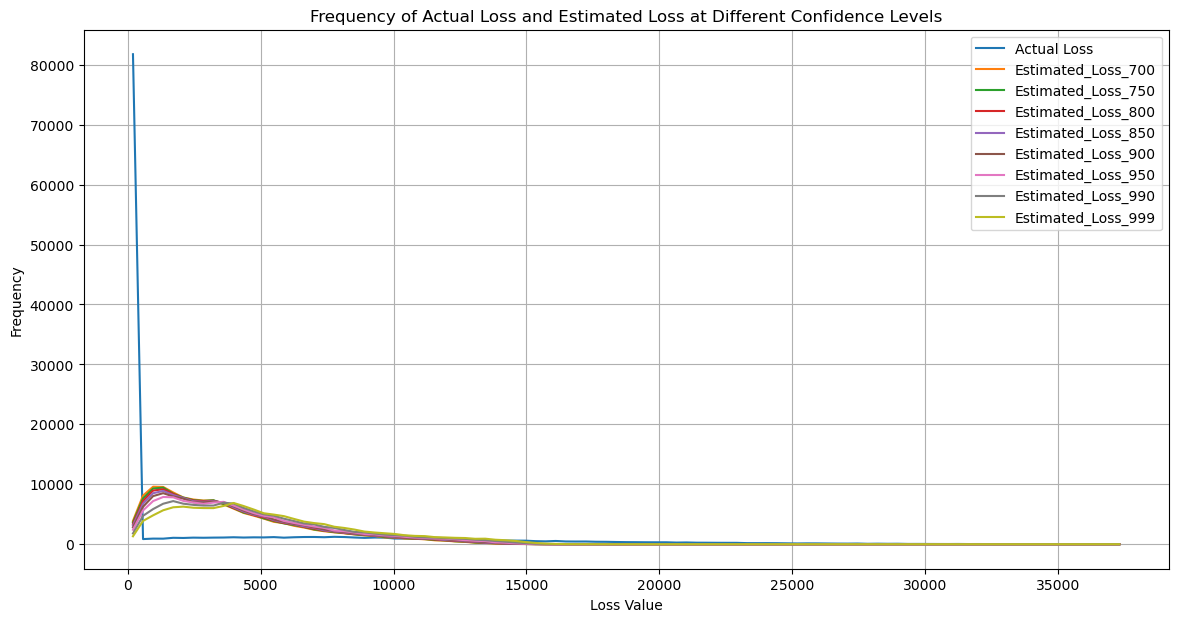

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define the columns to plot
loss_columns = {
    'loss': 'Actual Loss',
    'Estimated_Loss_700': 'Estimated_Loss_700',
    'Estimated_Loss_750': 'Estimated_Loss_750',   
    'Estimated_Loss_800': 'Estimated_Loss_800',
    'Estimated_Loss_850': 'Estimated_Loss_850',
    'Estimated_Loss_900': 'Estimated_Loss_900',
    'Estimated_Loss_950': 'Estimated_Loss_950',
    'Estimated_Loss_990': 'Estimated_Loss_990',
    'Estimated_Loss_999': 'Estimated_Loss_999'
}

# Check and remove any columns not in DataFrame
loss_columns = {k: v for k, v in loss_columns.items() if k in df_vasicek_final_efg.columns}

# Plot histogram lines
plt.figure(figsize=(14, 7))

# Determine bin edges for all histograms to align the bins
bins = np.linspace(
    min(df_vasicek_final_efg[list(loss_columns.keys())].min()), 
    max(df_vasicek_final_efg[list(loss_columns.keys())].max()), 
    100
)

# Plot a line for each specified column
for column, label in loss_columns.items():
    hist_values, _ = np.histogram(df_vasicek_final_efg[column], bins=bins)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    plt.plot(bin_centers, hist_values, label=label)

plt.xlabel('Loss Value')
plt.ylabel('Frequency')
plt.title('Frequency of Actual Loss and Estimated Loss at Different Confidence Levels')
plt.legend()
plt.grid(True)
plt.show()


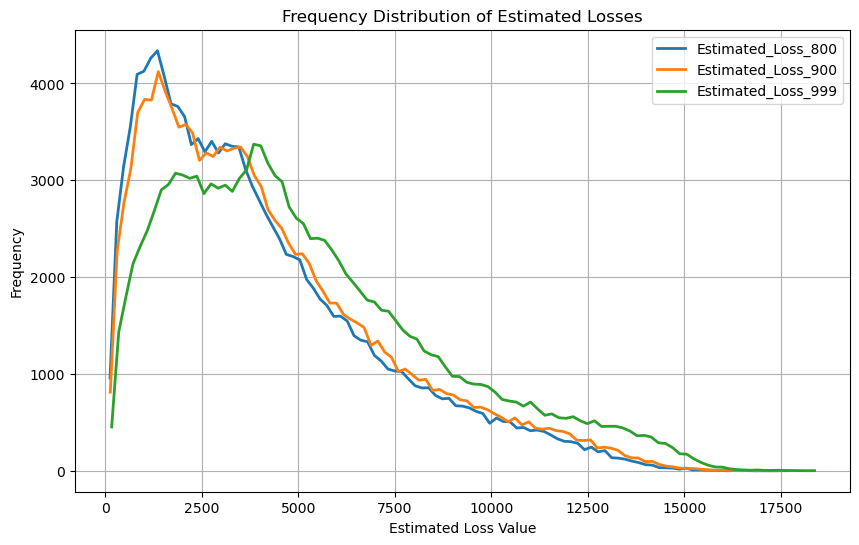

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame and it contains the specified columns
columns = [
    'Estimated_Loss_800',
   
    'Estimated_Loss_900',
       
    'Estimated_Loss_999'
]

# Create a figure for the histograms
plt.figure(figsize=(10, 6))

# Loop over the column names and plot a histogram for each
for column in columns:
    # Calculate histogram values and bins without probability density (i.e., frequency)
    hist_values, bin_edges = np.histogram(df_vasicek_final_efg[column], bins=100, density=False)

    # Calculate the bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plot the histogram (frequency)
    plt.plot(bin_centers, hist_values, label=f'{column}', linewidth=2)

# Add labels and title
plt.xlabel('Estimated Loss Value')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Estimated Losses')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'actual_class' equals 1
filtered_df = df_vasicek_final_fg[df_vasicek_final_fg['actual_class'] == 1]

# Calculate histogram values and bins for the 'loss' column
hist_values, bins = np.histogram(filtered_df['loss'], bins=100)

# Calculate the bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Plot the line plot for histogram
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, hist_values, label='Loss Distribution for Actual Class 1', linewidth=2, color='blue')

plt.xlabel('Loss Value')
plt.ylabel('Frequency')
plt.title('Histogram of Loss for Actual Class 1')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'df_vasicek_final_fg' is not defined

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'loss' values greater than 0 and 'actual_class' equals 1
filtered_df = df_vasicek_final_efg[(df_vasicek_final_efg['loss'] > 0) & (df_vasicek_final_efg['actual_class'] == 1)]

# Calculate histogram values and bins without probability density (i.e., frequency)
hist_values, bin_edges = np.histogram(filtered_df['loss'], bins=100, density=False)

# Calculate the bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Plot histogram for the 'loss' column with positive values and actual_class == 1
plt.figure(figsize=(10, 6))

# Plot the line plot for histogram (frequency)
plt.plot(bin_centers, hist_values, label='Positive Actual Loss for Class 1', linewidth=2)

plt.xlabel('Loss Value')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Positive Actual Loss for Class 1')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'df_vasicek_final_efg' is not defined

In [13]:
import pandas as pd
import numpy as np

# Assuming df_f_v_final is your DataFrame and is already loaded

# Group the DataFrame by 'issue_year' and 'issue_month'
grouped = df_vasicek_final_efg.groupby(['issue_year', 'issue_month'])

# Initialize a dictionary to store results
results = {
    'loss': [],
    'Estimated_Loss_700': [],
    'Estimated_Loss_750': [], 
    'Estimated_Loss_800': [],
    'Estimated_Loss_850': [],
    'Estimated_Loss_900': [],
    'Estimated_Loss_950': [],
    'Estimated_Loss_990': [],
    'Estimated_Loss_999': []
}

# Calculate sums for each group
for name, group in grouped:
    for key in results.keys():
        results[key].append(group[key].sum())

# Convert to DataFrame for easier comparison
results_df = pd.DataFrame(results, index=grouped.size().index.rename(['Year', 'Month']))

# Frequency of actual loss sum exceeding estimated loss sums
frequencies = {}
for col in results_df.columns[1:]:  # Skip the first column which is 'loss'
    frequencies[col] = np.sum(results_df['loss'] > results_df[col])

frequencies


{'Estimated_Loss_700': 37,
 'Estimated_Loss_750': 36,
 'Estimated_Loss_800': 35,
 'Estimated_Loss_850': 33,
 'Estimated_Loss_900': 32,
 'Estimated_Loss_950': 24,
 'Estimated_Loss_990': 17,
 'Estimated_Loss_999': 12}

In [14]:
# Group the DataFrame by 'issue_year' and 'issue_month'
grouped_counts = df_vasicek_final_efg.groupby(['issue_year']).size()

# Convert the result to a DataFrame for easier reading
counts_df = grouped_counts.reset_index(name='Count')

# Display the DataFrame
counts_df


,issue_year,Count
0,2012,4745
1,2013,14292
2,2014,25456
3,2015,38598
4,2016,27532
5,2017,15896
6,2018,3749


In [15]:
import pandas as pd

# Assuming df_f_vasicek_final is your DataFrame loaded in the environment

# List of columns to calculate the sum
columns_to_sum = [
    'Estimated_Loss_700', 'Estimated_Loss_750', 'Estimated_Loss_800', 
    'Estimated_Loss_850', 'Estimated_Loss_900', 'Estimated_Loss_950',
    'Estimated_Loss_990', 'Estimated_Loss_999'
]

# Calculate the sums of specified columns
sums = df_vasicek_final_efg[columns_to_sum].sum()

# Convert the series of sums to a DataFrame for a nicer display, and transpose it
sum_matrix = pd.DataFrame(sums, columns=["Total Sum"]).transpose()

# Display the DataFrame
print(sum_matrix)


           Estimated_Loss_700  Estimated_Loss_750  Estimated_Loss_800  \
Total Sum        5.041004e+08        5.142724e+08        5.256248e+08   

           Estimated_Loss_850  Estimated_Loss_900  Estimated_Loss_950  \
Total Sum        5.388821e+08        5.555845e+08        5.803398e+08   

           Estimated_Loss_990  Estimated_Loss_999  
Total Sum        6.265486e+08        6.775077e+08  


In [16]:
import numpy as np
from scipy.stats import chi2

# Total number of trials (days)
n = 84
# Observed number of exceedances for each confidence level
exceedances ={'Estimated_Loss_700': 37,
 'Estimated_Loss_750': 36,
 'Estimated_Loss_800': 35,
 'Estimated_Loss_850': 33,
 'Estimated_Loss_900': 32,
 'Estimated_Loss_950': 24,
 'Estimated_Loss_990': 17,
 'Estimated_Loss_999': 12}

# Calculate Kupiec's test statistic and p-value for each confidence level
results = {}
for level, exceptions in exceedances.items():
    # Extract the numeric value from the level key
    confidence_percentage = int(level.split('_')[-1])
    # Calculate p from the confidence percentage
    p = (1000 - confidence_percentage) / 1000
    
    # Handle edge cases for log calculations
    p = max(p, 1e-10)  # prevent log(0)
    q = 1 - p
    q = max(q, 1e-10)  # prevent log(0)
    proportion = exceptions / n
    proportion = max(proportion, 1e-10)  # prevent log(0)
    one_minus_proportion = 1 - proportion
    one_minus_proportion = max(one_minus_proportion, 1e-10)  # prevent log(0)
    
    # Compute the components for the Kupiec test
    ln_part_model = (n - exceptions) * np.log(q) + exceptions * np.log(p)
    ln_part_actual = (n - exceptions) * np.log(one_minus_proportion) + exceptions * np.log(proportion)
    test_statistic = -2 * (ln_part_model - ln_part_actual)
    
    # Calculate the p-value
    p_value = chi2.sf(test_statistic, 1)  # survival function for chi-squared distribution

    # Store the results
    results[level] = {
        'Test Statistic': test_statistic,
        'p-value': p_value,
        'Model Accepted': p_value > 0.05
    }

results

{'Estimated_Loss_700': {'Test Statistic': 7.366010141101555,
  'p-value': 0.006646825010417848,
  'Model Accepted': False},
 'Estimated_Loss_750': {'Test Statistic': 12.702111366323834,
  'p-value': 0.00036524295165654865,
  'Model Accepted': False},
 'Estimated_Loss_800': {'Test Statistic': 20.424253212603247,
  'p-value': 6.203856815167452e-06,
  'Model Accepted': False},
 'Estimated_Loss_850': {'Test Statistic': 29.22534120023346,
  'p-value': 6.44309945944572e-08,
  'Model Accepted': False},
 'Estimated_Loss_900': {'Test Statistic': 46.68216188600711,
  'p-value': 8.348549929895917e-12,
  'Model Accepted': False},
 'Estimated_Loss_950': {'Test Statistic': 49.441053574774415,
  'p-value': 2.0442265484365076e-12,
  'Model Accepted': False},
 'Estimated_Loss_990': {'Test Statistic': 73.30337381858838,
  'p-value': 1.1117771041814655e-17,
  'Model Accepted': False},
 'Estimated_Loss_999': {'Test Statistic': 97.03065727115461,
  'p-value': 6.826216610054319e-23,
  'Model Accepted': Fals